# Word embeddings
Import various modules that we need for this notebook (now using Keras 1.0.0)

In [12]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import imdb, reuters
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

from gensim.models import word2vec

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.

### I. Example using word embedding
We read in the IMDB dataset, using the next 500 most commonly used terms.

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=500, maxlen=100, test_split=0.2)
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

Let's look at one sample from X_train and the first 10 elements of y_train. The codes give indicies for the word in the vocabulary (unfortunately, we do not have access to the vocabulary for this set).

In [3]:
print(X_train[0])
print(y_train[:10])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  19 101 186
  17   9 243   2   7 295  17  23  57 102  19 158 131 129   9   2 328  32
   2   2  43  31   6  29  19  57 107  35  94 100  17  52   9 192  10  97
  95 101   7   5   2  13  80 103 171  25   2   2   9   2   6   9 154  21
 313  18  72 447 193  76  19 160   2  43]
[1 0 1 1 1 0 0 1 0 1]


We now construct a model, the layer of which is a vector embedding. We then have a dense layer and then the activation layer. Notice that the output of the Embedding needs to be Flattened.

In [4]:
model = Sequential()

model.add(Embedding(500, 32, input_length=100))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [5]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
          validation_data=(X_test, y_test))

Train on 1660 samples, validate on 416 samples
Epoch 1/10
1660/1660 [==============================] - 1s - loss: 0.6826 - acc: 0.5681 - val_loss: 0.6773 - val_acc: 0.5769
Epoch 2/10
1660/1660 [==============================] - 1s - loss: 0.6562 - acc: 0.5976 - val_loss: 0.6693 - val_acc: 0.5769
Epoch 3/10
1660/1660 [==============================] - 1s - loss: 0.5874 - acc: 0.7060 - val_loss: 0.6291 - val_acc: 0.6587
Epoch 4/10
1660/1660 [==============================] - 2s - loss: 0.4549 - acc: 0.8295 - val_loss: 0.5788 - val_acc: 0.6779
Epoch 5/10
1660/1660 [==============================] - 1s - loss: 0.3324 - acc: 0.8880 - val_loss: 0.5508 - val_acc: 0.7139
Epoch 6/10
1660/1660 [==============================] - 1s - loss: 0.2261 - acc: 0.9307 - val_loss: 0.5544 - val_acc: 0.7284
Epoch 7/10
1660/1660 [==============================] - 1s - loss: 0.1476 - acc: 0.9669 - val_loss: 0.6017 - val_acc: 0.7284
Epoch 8/10
1660/1660 [==============================] - 1s - loss: 0.0965 - ac

The accuracy is not terribly, and certainly better than random guessing, but the model is clearly overfitting. To test your understanding, would you have been able to guess the sizes of the weights in these layers? Where does the 3200 comes from the first Dense layer?

In [6]:
print(model.layers[0].get_weights()[0].shape) # Embedding
print(model.layers[3].get_weights()[0].shape) # Dense(256)
print(model.layers[6].get_weights()[0].shape) # Dense(1)

(500, 32)
(3200, 256)
(256, 1)


### II. Word embedding with 1D Convolutions
We can use 1-dimensional convolutions to learn local associations between words, rather than having to rely on global associations.

In [7]:
model = Sequential()

# embedding
model.add(Embedding(500, 32, input_length=100))
model.add(Dropout(0.25))

# convolution layers
model.add(Convolution1D(nb_filter=32,
                        filter_length=4,
                        border_mode='valid',
                        activation='relu'))
model.add(MaxPooling1D(pool_length=2))

# dense layers
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [8]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=15, verbose=1,
          validation_data=(X_test, y_test))

Train on 1660 samples, validate on 416 samples
Epoch 1/15
1660/1660 [==============================] - 3s - loss: 0.6842 - acc: 0.5729 - val_loss: 0.6807 - val_acc: 0.5769
Epoch 2/15
1660/1660 [==============================] - 2s - loss: 0.6799 - acc: 0.5771 - val_loss: 0.6792 - val_acc: 0.5769
Epoch 3/15
1660/1660 [==============================] - 3s - loss: 0.6707 - acc: 0.5801 - val_loss: 0.6693 - val_acc: 0.5793
Epoch 4/15
1660/1660 [==============================] - 2s - loss: 0.6281 - acc: 0.6404 - val_loss: 0.6100 - val_acc: 0.6611
Epoch 5/15
1660/1660 [==============================] - 2s - loss: 0.5283 - acc: 0.7422 - val_loss: 0.5381 - val_acc: 0.7284
Epoch 6/15
1660/1660 [==============================] - 3s - loss: 0.4238 - acc: 0.8024 - val_loss: 0.4990 - val_acc: 0.7452
Epoch 7/15
1660/1660 [==============================] - 3s - loss: 0.3752 - acc: 0.8253 - val_loss: 0.4481 - val_acc: 0.8005
Epoch 8/15
1660/1660 [==============================] - 3s - loss: 0.3257 - ac

The performance is significantly improved, and could be much better if we further tweaked the parameters and constructed a deeper model.

### III. Reuters classification
Let's use the same approach to do document classification on the Reuters corpus.

In [9]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(nb_words=500, maxlen=100, test_split=0.2)
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)
Y_train = np_utils.to_categorical(y_train, 46)
Y_test = np_utils.to_categorical(y_test, 46)

In [10]:
model = Sequential()

# embedding
model.add(Embedding(500, 32, input_length=100))
model.add(Dropout(0.25))

# convolution layers
model.add(Convolution1D(nb_filter=32,
                        filter_length=4,
                        border_mode='valid',
                        activation='relu'))
model.add(MaxPooling1D(pool_length=2))

# dense layers
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# output layer
model.add(Dense(46))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [11]:
model.fit(X_train, Y_train, batch_size=32, nb_epoch=15, verbose=1,
          validation_data=(X_test, Y_test))

Train on 4777 samples, validate on 1195 samples
Epoch 1/15
4777/4777 [==============================] - 9s - loss: 0.1423 - acc: 0.4712 - val_loss: 0.0569 - val_acc: 0.5146
Epoch 2/15
4777/4777 [==============================] - 9s - loss: 0.0571 - acc: 0.5102 - val_loss: 0.0510 - val_acc: 0.6259
Epoch 3/15
4777/4777 [==============================] - 7s - loss: 0.0496 - acc: 0.6006 - val_loss: 0.0460 - val_acc: 0.6285
Epoch 4/15
4777/4777 [==============================] - 8s - loss: 0.0463 - acc: 0.6427 - val_loss: 0.0445 - val_acc: 0.6745
Epoch 5/15
4777/4777 [==============================] - 8s - loss: 0.0451 - acc: 0.6636 - val_loss: 0.0440 - val_acc: 0.6870
Epoch 6/15
4777/4777 [==============================] - 8s - loss: 0.0444 - acc: 0.6695 - val_loss: 0.0437 - val_acc: 0.6845
Epoch 7/15
4777/4777 [==============================] - 8s - loss: 0.0440 - acc: 0.6753 - val_loss: 0.0429 - val_acc: 0.6921
Epoch 8/15
4777/4777 [==============================] - 8s - loss: 0.0435 - a

The results are less impressive than they may at first seem, as the majority of the articles are in one of three categories.

### IV. word2vec
Let's load in the pre-learned word2vec embeddings.

In [14]:
loc = "/Users/taylor/files/word2vec_python/GoogleNews-vectors-negative300.bin"
model = word2vec.Word2Vec.load_word2vec_format(loc, binary=True)

In [15]:
jobs = ["professor", "teacher", "actor", "clergy", "musician", "philosopher",
        "writer", "singer", "dancers", "model", "anesthesiologist", "audiologist",
        "chiropractor", "optometrist", "pharmacist", "psychologist", "physician",
        "architect", "firefighter", "judges", "lawyer", "biologist", "botanist",
        "ecologist", "geneticist",  "zoologist", "chemist", "programmer", "designer"]

In [40]:
print(model[jobs[0]].shape)
print(model[jobs[0]][:25])

array([ 0.25195312, -0.09960938,  0.2265625 ,  0.25390625,  0.18261719,
        0.33007812,  0.33007812, -0.39257812,  0.22558594, -0.41601562], dtype=float32)

In [20]:
embedding = np.array([model[x] for x in jobs])

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = np.transpose(pca.transform(embedding))
embedding_pca.shape

(2, 29)

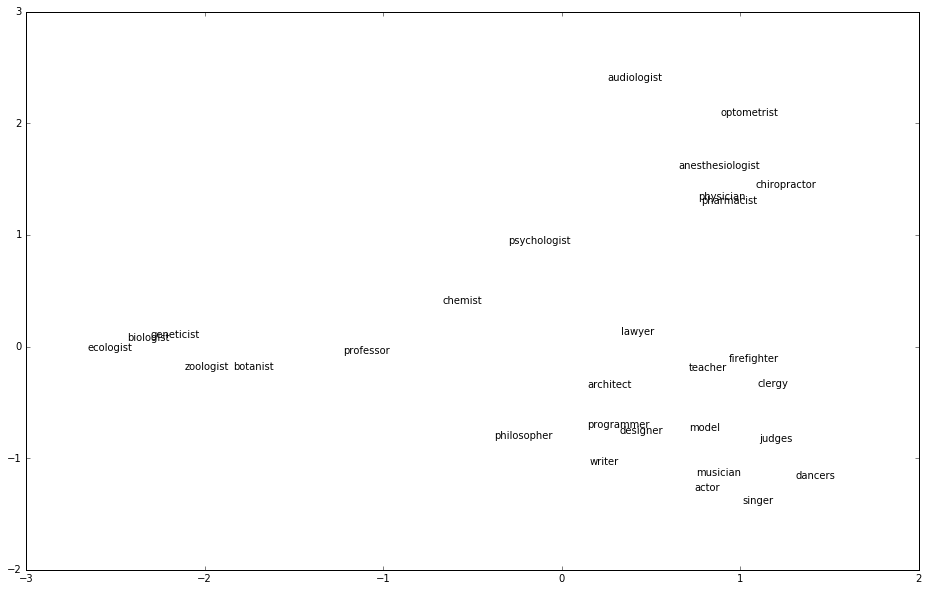

In [39]:
plt.figure(figsize=(16, 10))
plt.scatter(embedding_pca[0], embedding_pca[1], alpha=0)
for index,(x,y) in enumerate(np.transpose(embedding_pca)):
    plt.text(x,y,jobs[index])

Now, let's repeate with country clubs.

In [50]:
country = ["United_States", "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Argentina", 
"Armenia", "Australia", "Austria", "Azerbaijan", "Bahrain", "Bangladesh", 
"Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan", 
"Bolivia", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burundi", 
"Cambodia", "Cameroon", "Canada", "Chad", "Chile", "Colombia", 
"Comoros", "Croatia", "Cuba", "Cyprus", "Denmark", "Djibouti", 
"Dominica", "Ecuador", "Egypt", "Eritrea", "Estonia", "Ethiopia", 
"Fiji", "Finland", "France", "Gabon", "Georgia", "Germany", "Ghana", 
"Greece", "Grenada", "Guatemala", "Guinea", 
"Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", 
"Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", 
"Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait", 
"Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", 
"Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Macedonia", 
"Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", 
"Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", 
"Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", 
"Namibia", "Nauru", "Nepal", "Netherlands", "Nicaragua", "Niger", 
"Nigeria", "Norway", "Oman", "Pakistan", "Palau", "Panama", "Paraguay", 
"Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", 
"Russia", "Rwanda", "Samoa", "Senegal", "Serbia", "Seychelles", 
"Singapore", "Slovakia", "Slovenia", "Somalia", "Spain", "Sudan", 
"Suriname", "Swaziland", "Sweden", "Switzerland", "Syria", "Tajikistan", 
"Tanzania", "Thailand", "Togo", "Tonga", "Tunisia", "Turkey", 
"Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "Uruguay", "Uzbekistan", 
"Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe", 
"Abkhazia", "Somaliland", "Mayotte", "Niue", 
"Tokelau", "Guernsey", "Jersey", "Anguilla", "Bermuda", "Gibraltar", 
"Montserrat", "Guam", "Macau", "Greenland", "Guadeloupe", "Martinique", 
"Reunion", "Aland", "Aruba", "Svalbard", "Ascension"]

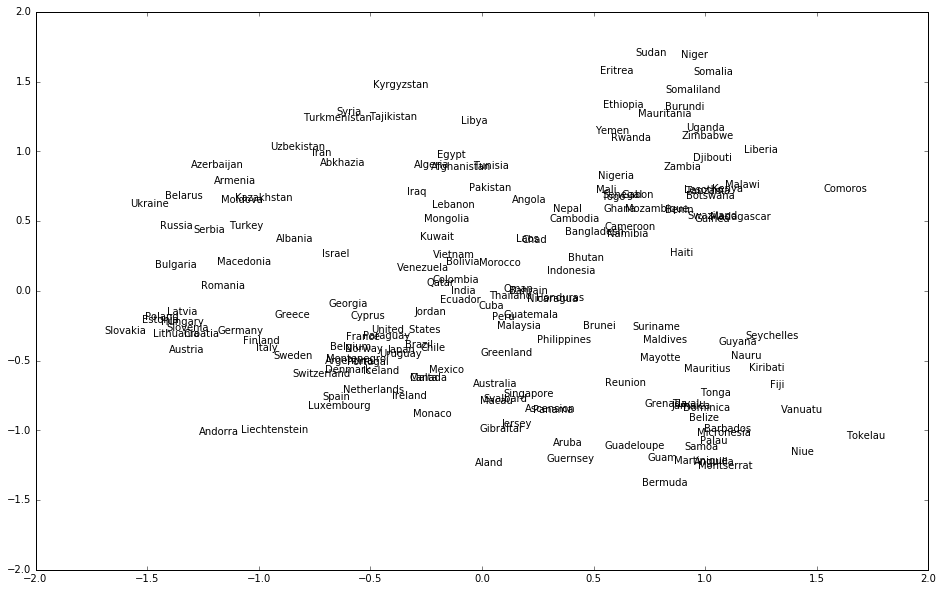

In [51]:
embedding = np.array([model[x] for x in country])
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = np.transpose(pca.transform(embedding))
embedding_pca.shape
plt.figure(figsize=(16, 10))
plt.scatter(embedding_pca[0], embedding_pca[1], alpha=0)
for index,(x,y) in enumerate(np.transpose(embedding_pca)):
    plt.text(x,y,country[index])

And, just because I think this is fun, let's run this on a smaller set of counties and their capitals.

In [60]:
city_pairs = ["Afghanistan", "Belarus", "Belgium", "Brazil", "Costa_Rica", 
"Canada", "Netherlands", "United_Kingdom", "United_States", "Iran", "Kabul", 
"Minsk", "Brussels", "Brasilia", "San_Jose", "Ottawa", "Amsterdam", 
"London", "Washington", "Tehran"]

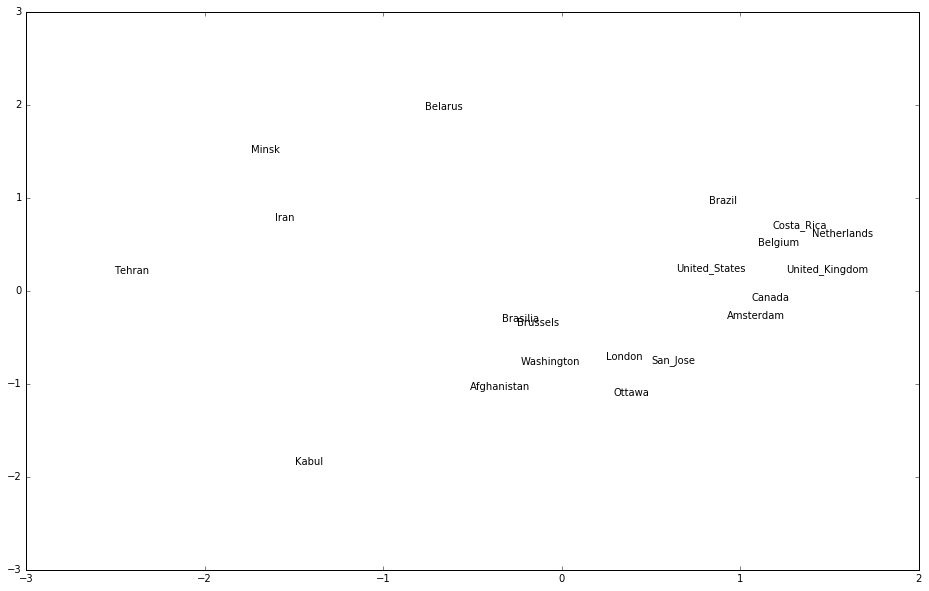

In [61]:
embedding = np.array([model[x] for x in city_pairs])
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = np.transpose(pca.transform(embedding))
embedding_pca.shape
plt.figure(figsize=(16, 10))
plt.scatter(embedding_pca[0], embedding_pca[1], alpha=0)
for index,(x,y) in enumerate(np.transpose(embedding_pca)):
    plt.text(x,y,city_pairs[index])

Look how the line between country and capital has roughly the same slope and length for all of the pairs.

It is by no means fast (the algorithm is horribly implemented in gensim) but we can also do the reverse, and find the closest words in the embedding space to a given term:

In [62]:
these = model.most_similar('Afghanistan', topn=25)
for th in these:
    print("%02.04f - %s" % th[::-1])